In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, List
from itertools import product
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
import seaborn as sns
from IPython.display import Video
import os
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data import Dataset
from torch import Tensor
from abc import ABC, abstractmethod
from torch.nn.functional import relu
from torch.utils.data.dataloader import DataLoader
from tqdm.notebook import tqdm
import scipy.stats as st
from src.sde.implementations import VPSDE
from src.sde.base import ItoSDE
from backward import run_backwards

In [2]:
image_size = 28
classes_by_index  = np.arange(0,10).astype('str')

transform = transforms.Compose([transforms.Resize(image_size),\
                                transforms.ToTensor(),\
                                transforms.Normalize([0.5],[0.5])]) #Normalize to -1,1
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                    download=True, transform=transform)

batch_size = 128
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

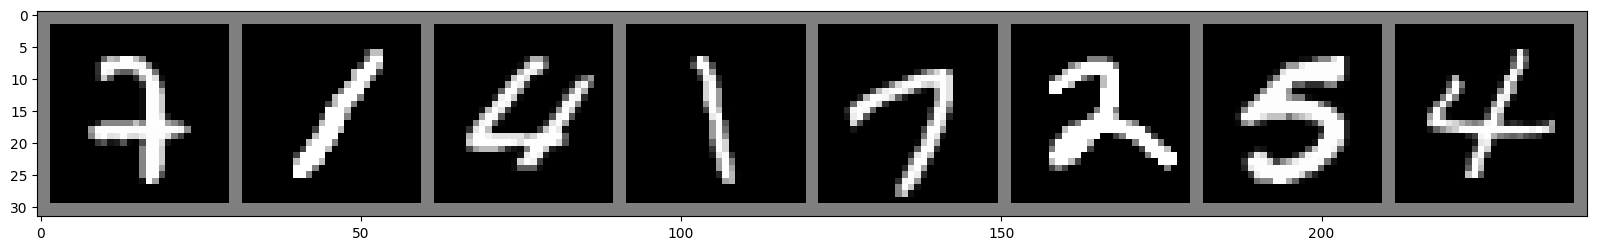

7     1     4     1     7     2     5     4    


In [3]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=[20, 20])
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
images = images[:8]
labels = labels[:8]

# show images
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes_by_index[labels[j]]:5s}' for j in range(8)))

In [4]:
class ESDE():
    def __init__(self, T_max: float, rate: float = 1,sigma: float=1,dim: int=2):
        self.T_max = T_max
        self.rate = rate
        self.sigma=sigma
        self.dim = dim


  

    def sample_random_levels (self, length: int):

        return torch.distributions.Exponential(rate=self.rate).sample((length,))

    @staticmethod
    def _mult_first_dim(level,X):
        """
        Helper function to multiply one-dimensional noise level vector with tensor of
        arbitrary shape.
        Inputs:
            X_0: shape (n,*,*,...,*)
            t: shape (n)
        Outputs:
            has same shape as X_0 - inputs X_0[i] multipled with t[i]
        """
        return level.view(-1,*[1]*(X.dim()-1))*X
    
    def run_forward(self, X_0: Tensor, level: Tensor, clip_factor: float = 0.01):
        """
        Function to evolve SDE forward in time from 0 to t<=self.T_max.
        Assume that conditional distribution is Gaussian
        Inputs:
            X_0: shape (n,*,*,...,*)
            t: shape (n)
        Outputs:
            X_t: shape as X_0 - noised input
            noise: shape as X_0 - noise converting X_0 to X_t
            score: shape as X_0 - score of conditional distribution q_t|0(X_t|X_0)
        """
        noise = torch.randn(size=X_0.shape)
        X_t = (X_0+self.sigma*self._mult_first_dim(torch.sqrt(level),noise))
        if clip_factor is not None:
            level=torch.clip(level,min=clip_factor)
        score=-self.dim*self._mult_first_dim(1/(torch.sqrt(level)*self.sigma),noise)

        return X_t, noise,score

    def run_forward_random_times(self, X_0: Tensor):
        """Function to evolve SDE forward until random times."""
        levels = self.sample_random_levels(X_0.shape[0])
        X_t, noise,score= self.run_forward(X_0,levels)
        return X_t, noise,score,levels


In [5]:
sde = ESDE(T_max=1,dim=1,rate=1/2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.2099698..3.4581616].


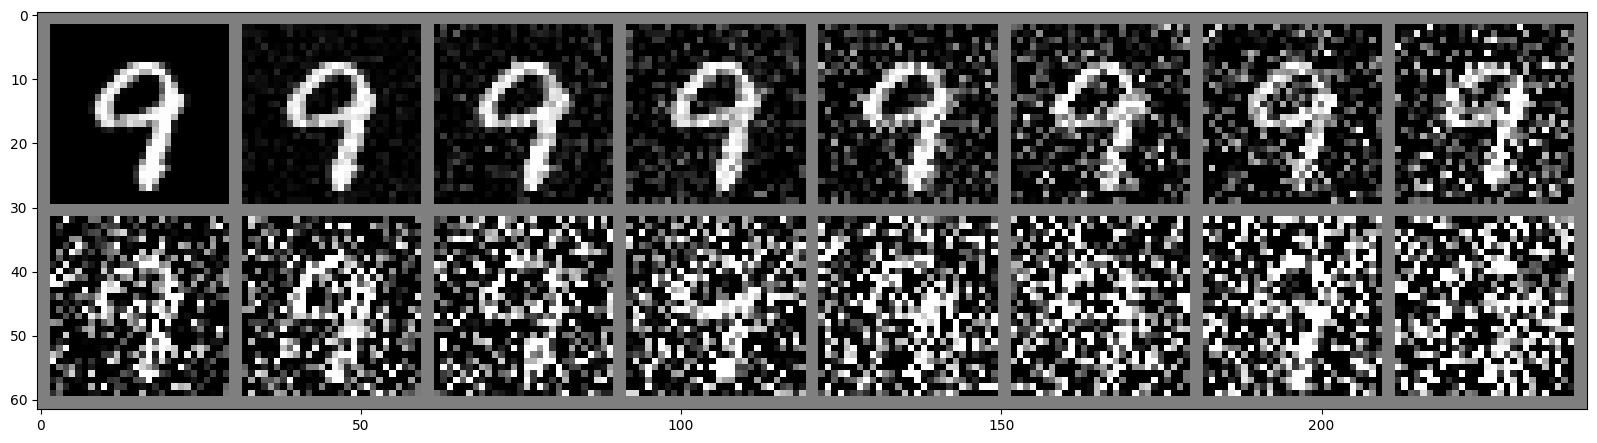

In [6]:
n_grid_points = 16
time_vec = torch.linspace(0,2,n_grid_points)**2
X_0 = torch.stack([trainset.__getitem__(23420)[0].unsqueeze(0).squeeze()]*n_grid_points)
X_t, noise, score = sde.run_forward(X_0,torch.linspace(0,2.0,n_grid_points)**2)
imshow(torchvision.utils.make_grid(X_t.unsqueeze(1)))

In [7]:
TRAIN_SCORE = True #whether to train score or denoiser network


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [9]:
class ChannelShuffle(nn.Module):
    def __init__(self,groups):
        super().__init__()
        self.groups=groups
    def forward(self,x):
        n,c,h,w=x.shape
        x=x.view(n,self.groups,c//self.groups,h,w) # group
        x=x.transpose(1,2).contiguous().view(n,-1,h,w) #shuffle
        
        return x

class ConvBnSiLu(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size,stride=1,padding=0):
        super().__init__()
        self.module=nn.Sequential(nn.Conv2d(in_channels,out_channels,kernel_size,stride=stride,padding=padding),
                                  nn.BatchNorm2d(out_channels),
                                  nn.SiLU(inplace=True))
    def forward(self,x):
        return self.module(x)

class ResidualBottleneck(nn.Module):
    '''
    shufflenet_v2 basic unit(https://arxiv.org/pdf/1807.11164.pdf)
    '''
    def __init__(self,in_channels,out_channels):
        super().__init__()

        self.branch1=nn.Sequential(nn.Conv2d(in_channels//2,in_channels//2,3,1,1,groups=in_channels//2),
                                    nn.BatchNorm2d(in_channels//2),
                                    ConvBnSiLu(in_channels//2,out_channels//2,1,1,0))
        self.branch2=nn.Sequential(ConvBnSiLu(in_channels//2,in_channels//2,1,1,0),
                                    nn.Conv2d(in_channels//2,in_channels//2,3,1,1,groups=in_channels//2),
                                    nn.BatchNorm2d(in_channels//2),
                                    ConvBnSiLu(in_channels//2,out_channels//2,1,1,0))
        self.channel_shuffle=ChannelShuffle(2)

    def forward(self,x):
        x1,x2=x.chunk(2,dim=1)
        x=torch.cat([self.branch1(x1),self.branch2(x2)],dim=1)
        x=self.channel_shuffle(x) #shuffle two branches

        return x

class ResidualDownsample(nn.Module):
    '''
    shufflenet_v2 unit for spatial down sampling(https://arxiv.org/pdf/1807.11164.pdf)
    '''
    def __init__(self,in_channels,out_channels):
        super().__init__()
        self.branch1=nn.Sequential(nn.Conv2d(in_channels,in_channels,3,2,1,groups=in_channels),
                                    nn.BatchNorm2d(in_channels),
                                    ConvBnSiLu(in_channels,out_channels//2,1,1,0))
        self.branch2=nn.Sequential(ConvBnSiLu(in_channels,out_channels//2,1,1,0),
                                    nn.Conv2d(out_channels//2,out_channels//2,3,2,1,groups=out_channels//2),
                                    nn.BatchNorm2d(out_channels//2),
                                    ConvBnSiLu(out_channels//2,out_channels//2,1,1,0))
        self.channel_shuffle=ChannelShuffle(2)

    def forward(self,x):
        x=torch.cat([self.branch1(x),self.branch2(x)],dim=1)
        x=self.channel_shuffle(x) #shuffle two branches

        return x

class TimeMLP(nn.Module):
    '''
    naive introduce timestep information to feature maps with mlp and add shortcut
    '''
    def __init__(self,embedding_dim,hidden_dim,out_dim):
        super().__init__()
        self.mlp=nn.Sequential(nn.Linear(embedding_dim,hidden_dim),
                                nn.SiLU(),
                               nn.Linear(hidden_dim,out_dim))
        self.act=nn.SiLU()
    def forward(self,x,t):
        t_emb=self.mlp(t).unsqueeze(-1).unsqueeze(-1)
        x=x+t_emb
  
        return self.act(x)
    
class EncoderBlock(nn.Module):
    def __init__(self,in_channels,out_channels,time_embedding_dim):
        super().__init__()
        self.conv0=nn.Sequential(*[ResidualBottleneck(in_channels,in_channels) for i in range(3)],
                                    ResidualBottleneck(in_channels,out_channels//2))

        self.time_mlp=TimeMLP(embedding_dim=time_embedding_dim,hidden_dim=out_channels,out_dim=out_channels//2)
        self.conv1=ResidualDownsample(out_channels//2,out_channels)
    
    def forward(self,x,t=None):
        x_shortcut=self.conv0(x)
        if t is not None:
            x=self.time_mlp(x_shortcut,t)
        x=self.conv1(x)

        return [x,x_shortcut]
        
class DecoderBlock(nn.Module):
    def __init__(self,in_channels,out_channels,time_embedding_dim):
        super().__init__()
        self.upsample=nn.Upsample(scale_factor=2,mode='bilinear',align_corners=False)
        self.conv0=nn.Sequential(*[ResidualBottleneck(in_channels,in_channels) for i in range(3)],
                                    ResidualBottleneck(in_channels,in_channels//2))

        self.time_mlp=TimeMLP(embedding_dim=time_embedding_dim,hidden_dim=in_channels,out_dim=in_channels//2)
        self.conv1=ResidualBottleneck(in_channels//2,out_channels//2)

    def forward(self,x,x_shortcut,t=None):
        x=self.upsample(x)
        x=torch.cat([x,x_shortcut],dim=1)
        x=self.conv0(x)
        if t is not None:
            x=self.time_mlp(x,t)
        x=self.conv1(x)

        return x        

class Unet(nn.Module):
    '''
    simple unet design without attention
    '''
    def __init__(self,timesteps,time_embedding_dim,in_channels=3,out_channels=2,base_dim=32,dim_mults=[2,4,8,16], temp: float = 20.0):
        super().__init__()
        assert isinstance(dim_mults,(list,tuple))
        assert base_dim%2==0 

        channels=self._cal_channels(base_dim,dim_mults)

        self.init_conv=ConvBnSiLu(in_channels,base_dim,3,1,1)
        #self.time_embedding=nn.Embedding(timesteps,time_embedding_dim)
        self.time_embedding=nn.Linear(timesteps,time_embedding_dim)

        self.encoder_blocks=nn.ModuleList([EncoderBlock(c[0],c[1],time_embedding_dim) for c in channels])
        self.decoder_blocks=nn.ModuleList([DecoderBlock(c[1],c[0],time_embedding_dim) for c in channels[::-1]])
    
        self.mid_block=nn.Sequential(*[ResidualBottleneck(channels[-1][1],channels[-1][1]) for i in range(2)],
                                        ResidualBottleneck(channels[-1][1],channels[-1][1]//2))

        self.final_conv=nn.Conv2d(in_channels=channels[0][0]//2,out_channels=out_channels,kernel_size=1)

        self.centers = nn.Parameter(torch.linspace(0,1,timesteps+1)[:-1]+0.5/timesteps,requires_grad=False)
        self.temp = temp
        

    def get_softmax(self, t):
        softmax_mat = F.softmax(-self.temp*torch.abs(t[:,None]-self.centers[None,:]), dim=1)
        return softmax_mat
        
    def get_time_emb(self,t):
        softmax_mat = self.get_softmax(t)
        t=self.time_embedding(softmax_mat)
    
        return t
        
    def forward(self,x,t=None):
        
        x=self.init_conv(x)
        
        if t is not None:
            t = self.get_time_emb(t)
            
        encoder_shortcuts=[]
        for encoder_block in self.encoder_blocks:
            x,x_shortcut=encoder_block(x,t)
            encoder_shortcuts.append(x_shortcut)
        x=self.mid_block(x)
        encoder_shortcuts.reverse()
        for decoder_block,shortcut in zip(self.decoder_blocks,encoder_shortcuts):
            x=decoder_block(x,shortcut,t)
        x=self.final_conv(x)

        return x

    def _cal_channels(self,base_dim,dim_mults):
        dims=[base_dim*x for x in dim_mults]
        dims.insert(0,base_dim)
        channels=[]
        for i in range(len(dims)-1):
            channels.append((dims[i],dims[i+1])) # in_channel, out_channel

        return channels

In [10]:
def train_diffusion_model(model, sde: ItoSDE, dataloader: DataLoader, optimizer, device, n_epochs: int, print_every: int, train_score: bool = TRAIN_SCORE,WEIGHT_DECAY: float = 0,scheduler=None,time_cond: bool = False):
    model.train()
    model = model.to(device)
    loss_function = nn.MSELoss(reduction='mean')
    running_loss_list = []

    for epoch in range(n_epochs):
        print(f"Epoch: {epoch}")
        running_loss = 0.0
        for idx, (x_inp,y_inp) in enumerate(dataloader):

            #Zero gradients:
            optimizer.zero_grad()

            #Run forward samples:
           
            X_t,noise,score,time = sde.run_forward_random_times(x_inp)

            #Send to device:
            X_t = X_t.to(device)
            noise = noise.to(device)
            score = score.to(device)
            time = time.to(device)
            if time_cond==False:
                time = None
            #Predict score:
            model_pred = model(X_t,time)

            #Compute loss:
            if train_score:
                loss = loss_function(score,model_pred)
            else:
                loss = loss_function(noise,model_pred)

            #Optimize:
            loss.backward()
            optimizer.step()
            if scheduler is not None:
                scheduler.step()

            # print statistics
            running_loss += loss.detach().item()

            if (idx+1) % print_every == 0:
                avg_loss = running_loss/print_every
                running_loss_list.append(avg_loss)
                running_loss = 0.0
                print(avg_loss)
    return model,running_loss_list

In [10]:
N_TIMESTEPS = 100
n_channels = 1

model = Unet(base_dim=image_size, in_channels=n_channels, out_channels=n_channels, time_embedding_dim=256, timesteps=N_TIMESTEPS, dim_mults=[2, 4], temp=100.0)
model = torch.compile(model)

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"


In [13]:
LEARNING_RATE = 1e-2 #2e-5
WEIGHT_DECAY = 0.0
N_EPOCHS = 100
RETRAIN = True   

if RETRAIN:
    optimizer = torch.optim.AdamW(model.parameters(),lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY,maximize=False)
    scheduler=torch.optim.lr_scheduler.OneCycleLR(optimizer,LEARNING_RATE,total_steps=N_EPOCHS*len(trainloader),pct_start=0.25,anneal_strategy='cos')
    
    model,running_loss_list = train_diffusion_model(model, sde, trainloader, train_score=TRAIN_SCORE, optimizer=optimizer, scheduler=scheduler, device=device, n_epochs=N_EPOCHS, print_every=100)
    torch.save(model.state_dict(),"20231120_mnist_diffusion_denoiser.ckpt")
    
else:
    model_state_dict = torch.load("20231120_mnist_diffusion_denoiser.ckpt")
    model.load_state_dict(model_state_dict)

Epoch: 0
2.277675303816795
1.3271136426925658
0.9566601192951203
0.8594097098708153
Epoch: 1
0.7815856918692589
0.699156382381916
0.7070504385232925
0.6760560294985771
Epoch: 2
0.5685422664880753
0.5870518037676811
0.5472201132774352
0.5077839535474777
Epoch: 3
0.5604730719327926
0.49600215882062915
0.5073254007101059
0.526547315120697
Epoch: 4
0.4788127325475216
0.4614567489922047
0.4806054216623306
0.44187362760305404
Epoch: 5
0.4989654779434204
0.41688870564103125
0.46252094611525535
0.4162207108736038
Epoch: 6
0.42638983368873595
0.42261214718222617
0.47219485834240915
0.42983940824866296
Epoch: 7
0.36064456060528755
0.3812139643728733
0.4558264520764351
0.43594728961586954
Epoch: 8
0.4332671363651752
0.3826114532351494
0.39485681384801863
0.3984336206316948
Epoch: 9
0.3336172813177109
0.44160703375935556
0.4105424052476883
0.3787219788134098
Epoch: 10
0.3950554455816746
0.35952714502811434
0.4206367053091526
0.37225102379918096
Epoch: 11
0.3495208366215229
0.3892114406824112
0.409

In [15]:
def run_backwards(model: torch.nn.Module, sde: ItoSDE, x_start: Tensor, device, train_score, n_steps: int = 10, plot_evolution: bool = True, clip_max: float = 1.0, clip_min: float = -1.0, dim_scale: float = 1.0, div_threshold: float = 15, **kwargs):
    """Function to run stochastic differential equation. We assume a deterministic initial distribution p_0."""
    model = model.to(device)
    model.eval()
    #Number of trajectories, dimension of data:
    n_traj = x_start.shape[0]
    ndim = x_start.dim()-1

    #Compute time grid for discretization and step size:
    time_grid = torch.linspace(sde.T_max, 0, n_steps)
    step_size = torch.tensor(sde.sigma**2 / n_steps)

    #Compute the random drift at every time point:
   

    #Sample random drift at every time point:
    noise = torch.randn(size=(n_steps,*list(x_start.shape)))
    random_drift_grid_sample = torch.sqrt(step_size) * noise

    #Initialize list of trajectory:
    x_traj = [x_start.to(device)]
    stopped = torch.zeros(x_start.shape[0], dtype=torch.bool).to(device)

    # Track the step at which each trajectory stops
    stopped_step = torch.full((x_start.shape[0],), n_steps, dtype=torch.int)

    if plot_evolution:
        fig, axs = plt.subplots(1, len(time_grid), figsize=(6*len(time_grid), 6))
    
    
    for idx, step_number in tqdm(enumerate(time_grid), total=n_steps):
        x = x_traj[idx].clone().detach().requires_grad_(True)
        random_drift_sample = random_drift_grid_sample[idx]
        model_estimate = model(x.to(device))

        if train_score:
            score_estimates = model_estimate*dim_scale
        else:
            level = torch.tensor(1.0)
            score_estimates = -sde._mult_first_dim(1 / (torch.sqrt(level) * sde.sigma), model_estimate) * sde.dim

        correction_term = (step_size * score_estimates)
        div = torch.zeros(x.shape[0])
        vector_length = torch.zeros(x.shape[0])

        # Modified gradient computation section
        score_estimates = score_estimates.reshape(score_estimates.shape[0], -1)
        score_estimates_norm= torch.sum(score_estimates**2,dim=1)

        # for i in range(x.shape[0]):
        #     if stopped[i]:
        #         continue
        #     grads = []
        #     for d in range(score_estimates.shape[1]):
        #         try:
        #             # Set create_graph and retain_graph to False
        #             grad = torch.autograd.grad(
        #                 score_estimates[i, d], 
        #                 x, 
        #                 retain_graph=True if d < score_estimates.shape[1]-1 else False,
        #                 create_graph=False,
        #                 allow_unused=True
        #             )[0]
        #             grads.append(grad.reshape(score_estimates.shape[0],-1)[i, d].item() if grad is not None else 0.0)
        #         except Exception:
        #             grads.append(0.0)
            
        #     div[i] = sum(grads)
        #     vector_length[i] = torch.sum(score_estimates[i] ** 2)
        # stop when score is karger 
        #Save step:
        mask = (score_estimates_norm > torch.tensor(10000000).to(device)) & (~stopped)
        change = torch.zeros_like(correction_term)
        change[mask] = correction_term[mask]

        # Mark stop step only once
        newly_stopped = (~mask) & (~stopped)
        stopped_step[newly_stopped] = idx

        # Update stop flags
        stopped = stopped | newly_stopped
        next_step = x.to(device) + change.to(device)

        if plot_evolution:
            axs[idx].scatter(next_step[:,0],next_step[:,1])
            axs[idx].quiver(next_step[:,0],next_step[:,1],change[:,0],change[:,1])
            axs[idx].set_xlim(-2.0,2.0)
            axs[idx].set_ylim(-2.0,2.0)
            axs[idx].set_title(f"Step={idx}")
        x_traj.append(next_step)
    
    output = torch.stack(x_traj) #.transpose(1,0)
    #output = torch.clip(output, clip_min, clip_max)
    avg_steps = stopped_step.float().mean().item()

    # Compute fraction of stopped trajectories
    num_stopped = (stopped_step < n_steps).sum().item()
    fraction_stopped = num_stopped / n_traj

    print(f"🔁 Average number of steps until stopping: {avg_steps:.2f} out of max {n_steps}")
    print(f"🛑 Fraction of stopped trajectories: {fraction_stopped * 100:.1f}% ({num_stopped} out of {n_traj})")


    output = torch.stack(x_traj)
    return output,time_grid

In [13]:
model_state_dict = torch.load("20231120_mnist_diffusion_denoiser.ckpt")
model.load_state_dict(model_state_dict)

<All keys matched successfully>

In [16]:
model = model.to(device)
torch._functorch.config.donated_buffer = False
x_start = torch.clip(torch.randn(size=next(iter(trainloader))[0].shape)[:64],-1.0,1.0) # I over parameter of exponential
output,time_grid = run_backwards(model,sde,x_start=x_start,n_steps=100,device=device,train_score=TRAIN_SCORE, clip_min=-10.0, clip_max=10.0,plot_evolution=False,dim_scale=1)

  0%|          | 0/100 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 23.54 GiB of which 64.56 MiB is free. Process 2985 has 390.70 MiB memory in use. Process 372752 has 2.03 GiB memory in use. Including non-PyTorch memory, this process has 19.42 GiB memory in use. Of the allocated memory 17.58 GiB is allocated by PyTorch, and 1.40 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [20]:
output.shape

torch.Size([11, 64, 1, 28, 28])

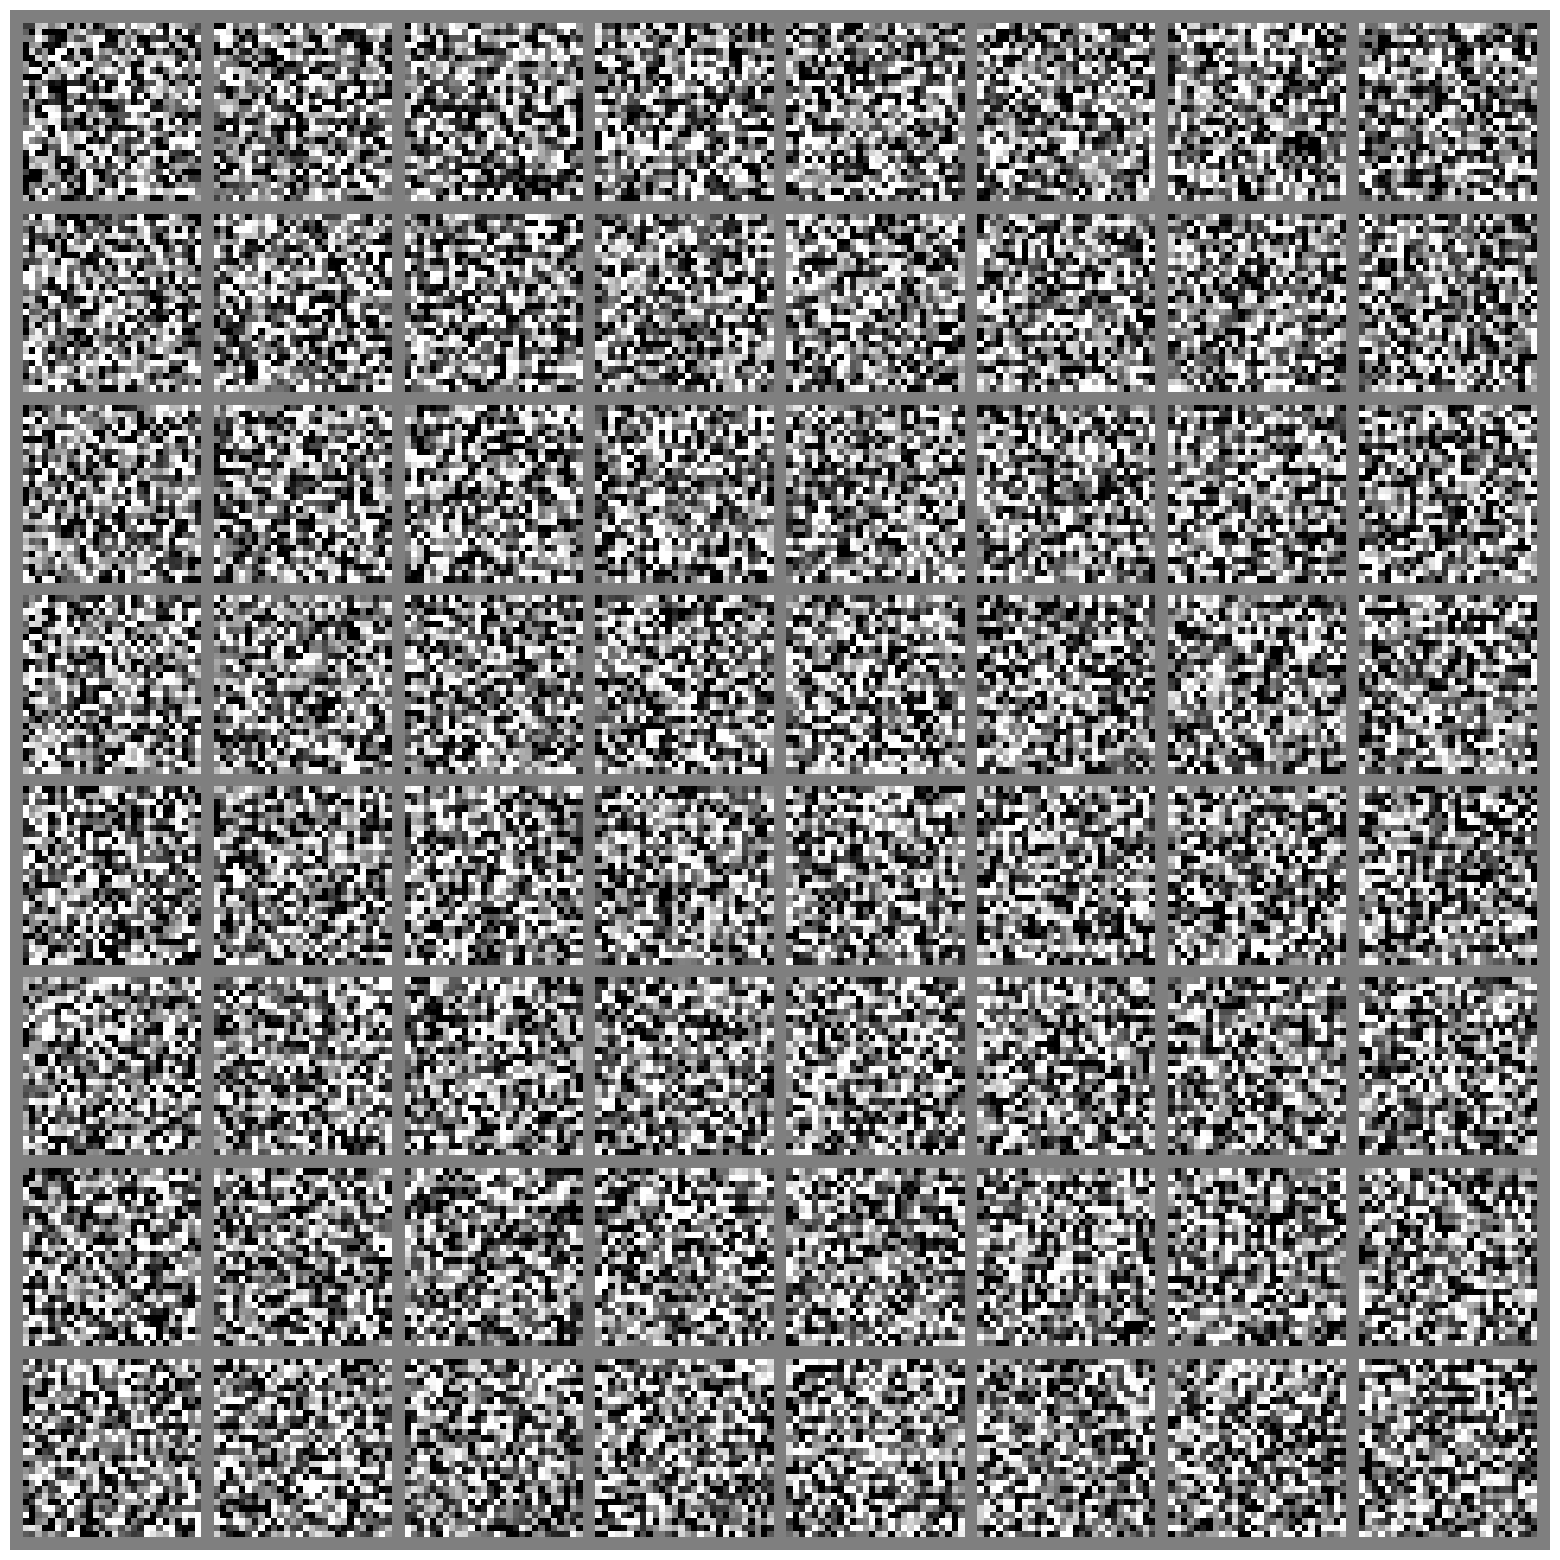

In [21]:
def imshow(img):
    img = (img + 1)/2     # normalize from [-1,1] to [0,1]
    img = torch.clamp(img, 0, 1)  # ensure values are in valid range
    npimg = img.numpy()
    plt.figure(figsize=[20, 20])
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')  # hide axes
    plt.show()

# When displaying the output:
imshow(torchvision.utils.make_grid(output[-1].detach().cpu())) 

In [40]:
model = model.to(device)
x_start = torch.clip(torch.randn(size=next(iter(trainloader))[0].shape)[:64],-1.0,1.0)
output,time_grid = run_backwards(model,sde,x_start=x_start,n_steps=10,device=device,train_score=TRAIN_SCORE, clip_min=-10.0, clip_max=10.0,plot_evolution=False,dim_scale=784)

  0%|          | 0/10 [00:00<?, ?it/s]

🔁 Average number of steps until stopping: 9.00 out of max 10
🛑 Fraction of stopped trajectories: 100.0% (64 out of 64)


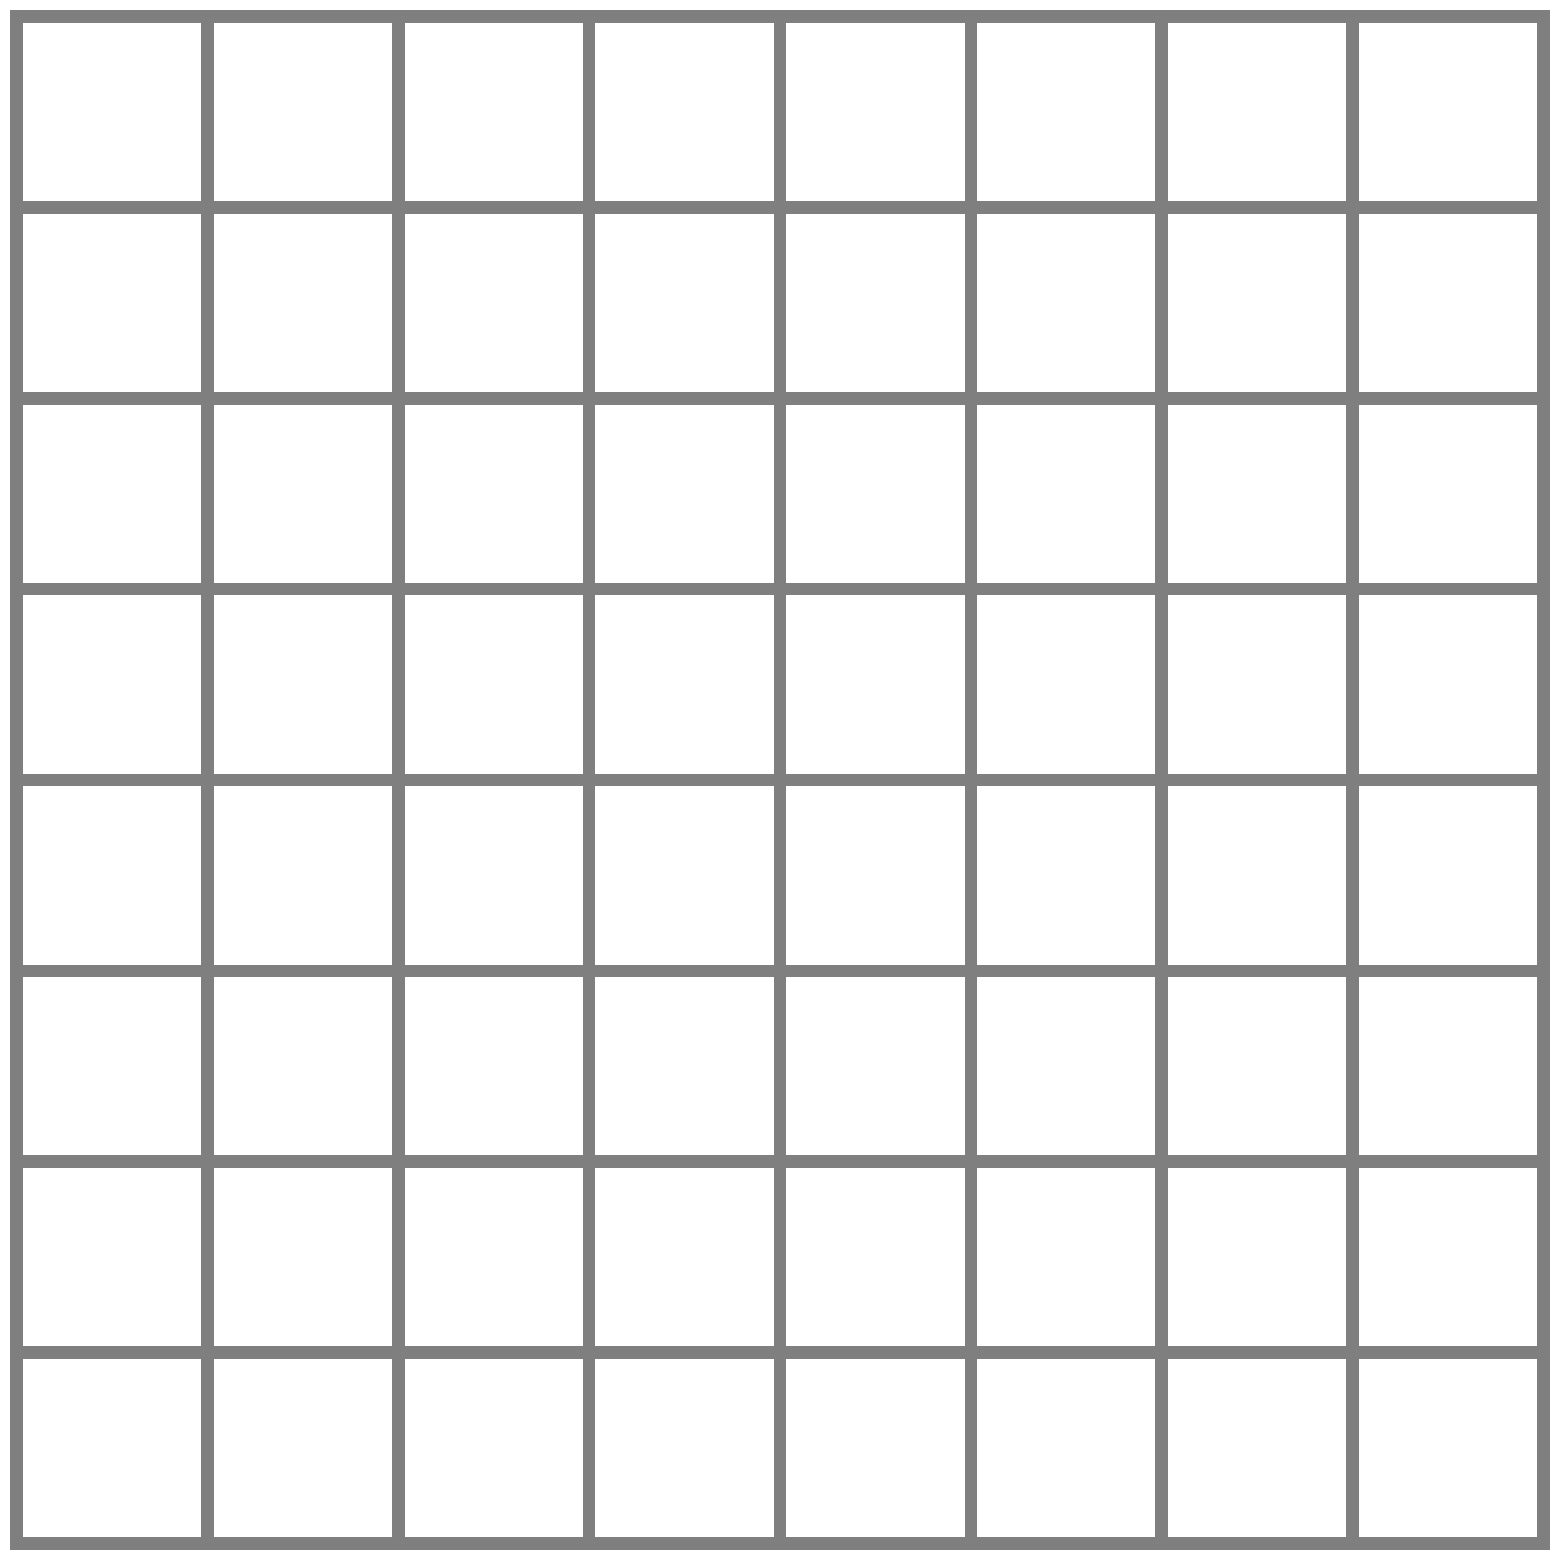

In [41]:
def imshow(img):
    img = (img + 1)/2     # normalize from [-1,1] to [0,1]
    img = torch.clamp(img, 0, 1)  # ensure values are in valid range
    npimg = img.numpy()
    plt.figure(figsize=[20, 20])
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')  # hide axes
    plt.show()

# When displaying the output:
imshow(torchvision.utils.make_grid(output[-1].detach().cpu())) 

In [ ]:
def imshow(img):
    img = (img + 1)/2     # normalize from [-1,1] to [0,1]
    img = torch.clamp(img, 0, 1)  # ensure values are in valid range
    npimg = img.numpy()
    plt.figure(figsize=[20, 20])
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')  # hide axes
    plt.show()

# When displaying the output:
imshow(torchvision.utils.make_grid(output[-1])) 

In [ ]:
model = model.to(device)
x_start = torch.clip(torch.randn(size=next(iter(trainloader))[0].shape)[:64],-1.0,1.0)
output,time_grid = run_backwards(model,sde,x_start=x_start,n_steps=100,device=device,train_score=TRAIN_SCORE, clip_min=-10.0, clip_max=10.0,plot_evolution=False)

In [ ]:
def imshow(img):
    img = (img + 1)/2     # normalize from [-1,1] to [0,1]
    img = torch.clamp(img, 0, 1)  # ensure values are in valid range
    npimg = img.numpy()
    plt.figure(figsize=[20, 20])
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')  # hide axes
    plt.show()

# When displaying the output:
imshow(torchvision.utils.make_grid(output[-1])) 

In [ ]:
model = model.to(device)
x_start = torch.clip(torch.randn(size=next(iter(trainloader))[0].shape)[:64],-1.0,1.0)
output,time_grid = run_backwards(model,sde,x_start=x_start,n_steps=50,device=device,train_score=TRAIN_SCORE, clip_min=-10.0, clip_max=10.0,plot_evolution=False)

In [ ]:
imshow(torchvision.utils.make_grid(output[-1])) 

In [ ]:
model = model.to(device)
x_start = torch.clip(torch.randn(size=next(iter(trainloader))[0].shape)[:64],-1.0,1.0)
output,time_grid = run_backwards(model,sde,x_start=x_start,n_steps=10,device=device,train_score=TRAIN_SCORE, clip_min=-10.0, clip_max=10.0,plot_evolution=False)

In [ ]:
imshow(torchvision.utils.make_grid(output[-1]))